<a href="https://colab.research.google.com/github/JoyceTsaiTsai/MySQL/blob/main/Mysql_Side_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#MySQL資料分析，side project 4：



#從各個角度分析A公司1996～1998年的各種業務數據，從中來評估A公司的：
#【員工能力評估、員工銷售績效分析】、
#【客群分析（國家客群、客戶購買力、活躍客戶）】、
#【熱門銷售產品分析、受喜愛產品分析】、
#【逐年逐月業績分析】
#最後請寫份摘要報告。請多用定量描述的方式，來證明你分析觀點的可靠性、準確性與權威性，以建立個人數據分析的品牌與形象。

---


#安裝mysql的python的驅動程式碼

In [ ]:
!pip install pymysql

---
# 1.找出未曾下單的客戶資料
#目的：找出本公司的待開發之潛在客戶

In [ ]:
import pandas as pd
sql = '''
select customers.CustomerID,customers.CompanyName,customers.ContactName from customers
left join orders
	on customers.CustomerID=orders.CustomerID
where OrderID is null;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-27-9756feb1d8db>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,ContactName
0,FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel
1,PARIS,Paris spcialits,Marie Bertrand
2,Val2,IT,Val2
3,VALON,IT,Valon Hoti


---
# 2.根據訂單數量為產品分類
若產品的訂單數量<10，則標示『銷量差』

若產品的訂單數量<=20 而且>=10，則標示『銷量普通』

若產品的訂單數量>20，則標示『銷量好』
#目的：將本公司產品，進行分類【銷量差，銷量普通，銷量好】

In [ ]:
import pandas as pd
sql = '''
SELECT `order details`.ProductID,products.ProductName,
	case
		when count(`order details`.ProductID)>20 then '銷量好'
		when count(`order details`.ProductID)<=20 and count(`order details`.ProductID)>=10 then '銷量普通'
		else '銷量差'
	end as 產品銷量等級
FROM `order details`
join products
	on `order details`.ProductID=products.ProductID
group by `order details`.ProductID;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-28-c67d3a3154d9>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,產品銷量等級
0,17,Alice Mutton,銷量好
1,3,Aniseed Syrup,銷量普通
2,40,Boston Crab Meat,銷量好
3,60,Camembert Pierrot,銷量好
4,18,Carnarvon Tigers,銷量好
...,...,...,...
72,7,Uncle Bob's Organic Dried Pears,銷量好
73,50,Valkoinen suklaa,銷量普通
74,63,Vegie-spread,銷量普通
75,64,Wimmers gute Semmelkndel,銷量好


---
# 3.根據銷售金額，對員工進行排名
#目的：找出表現好的員工並予以嘉獎，也找出表現差的員工，先輔導，再不行則辭退
不需要考慮【Order Details】裡面的Discount

#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
import pandas as pd
sql = '''
SELECT employees.EmployeeID,employees.FirstName,employees.LastName,RANK() OVER (order by sum(UnitPrice*Quantity)desc) AS 銷售排名 FROM `order details`
join orders
	on `order details`.OrderID=orders.OrderID
join employees
	on orders.EmployeeID=employees.EmployeeID
group by employees.EmployeeID;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-29-053ff0ed6ee9>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,EmployeeID,FirstName,LastName,銷售排名
0,4,Margaret,Peacock,1
1,3,Janet,Leverling,2
2,1,Nancy,Davolio,3
3,2,Andrew,Fuller,4
4,7,Robert,King,5
5,8,Laura,Callahan,6
6,9,Anne,Dodsworth,7
7,6,Michael,Suyama,8
8,5,Steven,Buchanan,9


---
# 4.根據國家來統計客戶數量
#目的：評估本公司海外客戶，哪些國家是主要客群

In [ ]:
import pandas as pd
sql = '''
SELECT Country,count(CustomerID) 客戶數量 FROM customers
group by Country;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-30-ad9a22d397b9>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,Country,客戶數量
0,Germany,11
1,Mexico,5
2,UK,7
3,Sweden,2
4,France,11
5,Spain,5
6,Canada,3
7,Argentina,3
8,Switzerland,2
9,Brazil,9


---
# 5.找出至少下過5個訂單的客戶

#目的：找出本公司的活躍客戶，不斷重複下單

In [ ]:
import pandas as pd
sql = '''
SELECT customers.CustomerID,customers.CompanyName,count(orders.OrderID) 下單次數
FROM customers
join orders
	on customers.CustomerID=orders.CustomerID
group by customers.CustomerID
having count(orders.OrderID) >=5;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-31-2e40c20897dd>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,下單次數
0,ALFKI,Alfreds Futterkiste,6
1,ANTON,Antonio Moreno Taquera,7
2,AROUT,Around the Horn,13
3,BERGS,Berglunds snabbkp,18
4,BLAUS,Blauer See Delikatessen,7
...,...,...,...
68,WARTH,Wartian Herkku,15
69,WELLI,Wellington Importadora,9
70,WHITC,White Clover Markets,14
71,WILMK,Wilman Kala,7


---
#6.計算每個產品類別銷售額，佔總銷售額的百分比
#目的：分析本公司各類產品，哪些是佔營收大宗的主要銷售大類？
不需要考慮【Order Details】裡面的Discount

#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
import pandas as pd
sql = '''
select categories.CategoryName,(100*銷售額/(select sum(`order details`.UnitPrice*`order details`.Quantity) from `order details`)) 佔比 from categories
join
(SELECT products.CategoryID,sum(`order details`.UnitPrice*`order details`.Quantity) 銷售額 FROM products
join `order details`
	on products.ProductID=`order details`.ProductID
group by products.CategoryID) as t1
	on categories.CategoryID=t1.CategoryID;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-32-7185643657de>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CategoryName,佔比
0,Beverages,21.154353
1,Condiments,8.394110
2,Confections,13.075269
3,Dairy Products,18.555791
4,Grains/Cereals,7.436684
5,Meat/Poultry,13.155722
6,Produce,7.772006
7,Seafood,10.456066


---
# 7.製作不同員工，在不同國家的訂單數量分析表
#目的：評估不同員工，對不同國家的銷售能力

In [ ]:
import pandas as pd
sql = '''
SELECT employees.FirstName,employees.LastName,orders.ShipCountry,count(orders.OrderID) 訂單數量 FROM orders
join employees
	on orders.EmployeeID=employees.EmployeeID
group by orders.EmployeeID,orders.ShipCountry;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-33-6e1b70b04f45>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,FirstName,LastName,ShipCountry,訂單數量
0,Nancy,Davolio,Austria,5
1,Nancy,Davolio,Finland,2
2,Nancy,Davolio,Italy,5
3,Nancy,Davolio,Germany,19
4,Nancy,Davolio,Brazil,11
...,...,...,...,...
162,Anne,Dodsworth,Venezuela,1
163,Anne,Dodsworth,Finland,1
164,Anne,Dodsworth,Argentina,2
165,Anne,Dodsworth,Portugal,1


---
# 8.找出所有訂單中最昂貴單價的前5個產品
#目的：評估本公司有被下訂的產品，哪些的CP值高（單價高，又有人買）

In [ ]:
import pandas as pd
sql = '''
SELECT `order details`.ProductID,products.ProductName,MAX(`order details`.UnitPrice) AS 最昂貴價錢
FROM `order details`
JOIN products
    ON `order details`.ProductID = products.ProductID
GROUP BY
    `order details`.ProductID,products.ProductName
ORDER BY 最昂貴價錢 DESC
LIMIT 5;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-34-0682ce3e4f70>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,最昂貴價錢
0,38,Cte de Blaye,263.50
1,29,Thringer Rostbratwurst,123.79
2,9,Mishi Kobe Niku,97.00
3,20,Sir Rodney's Marmalade,81.00
4,18,Carnarvon Tigers,62.50


---
# 9.找出所有訂單中還未發貨的訂單資料

In [ ]:
import pandas as pd
sql = '''
SELECT OrderID,CustomerID,OrderDate,ShippedDate FROM orders
where ShippedDate is null;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-35-b20e6fb95d96>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,OrderID,CustomerID,OrderDate,ShippedDate
0,11008,ERNSH,1998-04-08,None
1,11019,RANCH,1998-04-13,None
2,11039,LINOD,1998-04-21,None
3,11040,GREAL,1998-04-22,None
4,11045,BOTTM,1998-04-23,None
5,11051,LAMAI,1998-04-27,None
6,11054,CACTU,1998-04-28,None
7,11058,BLAUS,1998-04-29,None
8,11059,RICAR,1998-04-29,None
9,11061,GREAL,1998-04-30,None


---
# 10.顯示每個客戶的平均訂單金額，請依照平均訂單金額排序
#目的：評估每個客戶的購買能力，從此來評估哪些客戶是有購買力的大客戶（富豪）

不需要考慮【Order Details】裡面的Discount


#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
import pandas as pd
sql = '''
SELECT customers.CustomerID,customers.CompanyName,AVG(`order details`.UnitPrice*`order details`.Quantity) 平均訂單金額 FROM customers
JOIN orders
	ON orders.CustomerID=customers.CustomerID
JOIN `order details`
	ON orders.OrderID=`order details`.OrderID
group by customers.CustomerID
ORDER BY AVG(`order details`.UnitPrice*`order details`.Quantity) DESC;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-36-df276ba610df>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,平均訂單金額
0,QUICK,QUICK-Stop,1366.085930
1,SIMOB,Simons bistro,1209.230000
2,PICCO,Piccolo und mehr,1141.736957
3,ERNSH,Ernst Handel,1110.163529
4,HANAR,Hanari Carnes,1065.660938
...,...,...,...
84,NORTS,North/South,108.166667
85,ROMEY,Romero y tomillo,104.806429
86,GALED,Galera del gastrnomo,104.587500
87,LAUGB,Laughing Bacchus Wine Cellars,65.312500


---
# 11.統計每個類別下的產品數量。

In [ ]:
import pandas as pd
sql = '''
SELECT categories.CategoryName,COUNT(products.ProductID) 產品數量 FROM categories
JOIN products
	ON categories.CategoryID=products.CategoryID
group by categories.CategoryName;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-37-0837e4b50209>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CategoryName,產品數量
0,Beverages,12
1,Condiments,12
2,Confections,13
3,Dairy Products,10
4,Grains/Cereals,7
5,Meat/Poultry,6
6,Produce,5
7,Seafood,12


---
# 12.找出銷售總額低於平均水準的員工
#找出需要再教育訓練，需要再加強行銷能力的員工
不需要考慮【Order Details】裡面的Discount

#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**


In [ ]:
#找出平均銷售總額 #'150495.39888889'
import pandas as pd
sql = '''
SELECT AVG(銷售總額) FROM
(SELECT employees.EmployeeID,employees.FirstName,employees.LastName,SUM(`order details`.UnitPrice*`order details`.Quantity) 銷售總額 FROM `order details`
JOIN orders
	ON `order details`.OrderID=orders.OrderID
JOIN employees
	ON orders.EmployeeID=employees.EmployeeID
group by employees.EmployeeID) AS T1;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-44-f0c44825ea8e>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,AVG(銷售總額)
0,150495.398889


In [ ]:
import pandas as pd
sql = '''
SELECT
    employees.EmployeeID,
    employees.FirstName,
    employees.LastName,
    SUM(`order details`.UnitPrice * `order details`.Quantity) AS 銷售總額
FROM
    `order details`
JOIN orders
    ON `order details`.OrderID = orders.OrderID
JOIN employees
    ON orders.EmployeeID = employees.EmployeeID
GROUP BY
    employees.EmployeeID
HAVING
    SUM(`order details`.UnitPrice * `order details`.Quantity) < 150495.39888889
ORDER BY
    EmployeeID;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-45-51118f9f4134>:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,EmployeeID,FirstName,LastName,銷售總額
0,5,Steven,Buchanan,75567.75
1,6,Michael,Suyama,78198.10
2,7,Robert,King,141295.99
3,8,Laura,Callahan,133301.03
4,9,Anne,Dodsworth,82964.00


---
# 13.顯示所有訂單的總銷售額
不需要考慮【Order Details】裡面的Discount


#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
import pandas as pd
sql = '''
SELECT SUM(UnitPrice*Quantity) 總銷售額 FROM `order details`;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-39-b067dc63e94e>:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,總銷售額
0,1354458.59


---
# 14.列出至少有5個不同客戶下訂單的產品
#目的：查詢本公司收客戶歡迎的產品：只要被5個以上客戶下訂，就表示該產品受歡迎


#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
import pandas as pd
sql = '''
SELECT `order details`.ProductID,products.ProductName,COUNT(DISTINCT orders.CustomerID) 客戶下單數 FROM orders
JOIN `order details`
	ON orders.OrderID=`order details`.OrderID
JOIN products
	ON products.ProductID=`order details`.ProductID
group by `order details`.ProductID
HAVING COUNT(DISTINCT orders.CustomerID)>=5;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-40-7083df1bbe32>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,客戶下單數
0,1,Chai,31
1,2,Chang,28
2,3,Aniseed Syrup,10
3,4,Chef Anton's Cajun Seasoning,17
4,5,Chef Anton's Gumbo Mix,9
...,...,...,...
72,73,Rd Kaviar,11
73,74,Longlife Tofu,11
74,75,Rhnbru Klosterbier,33
75,76,Lakkalikri,33


---
# 15.找出至少向本公司購買過3種不同產品的客戶資料
#目的：找出本公司的活躍客戶，或喜歡本公司產品的客戶（購買多種產品）

#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
import pandas as pd
sql = '''
SELECT customers.CustomerID,customers.CompanyName,COUNT(DISTINCT `order details`.ProductID) 購買不同產品數量 FROM customers
JOIN orders
	ON orders.CustomerID=customers.CustomerID
JOIN `order details`
	ON orders.OrderID=`order details`.OrderID
group by customers.CustomerID
HAVING COUNT(DISTINCT `order details`.ProductID)>=3;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-41-1e33114a69bf>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,購買不同產品數量
0,ALFKI,Alfreds Futterkiste,11
1,ANATR,Ana Trujillo Emparedados y helados,10
2,ANTON,Antonio Moreno Taquera,15
3,AROUT,Around the Horn,24
4,BERGS,Berglunds snabbkp,37
...,...,...,...
82,WARTH,Wartian Herkku,28
83,WELLI,Wellington Importadora,16
84,WHITC,White Clover Markets,32
85,WILMK,Wilman Kala,17


---
# 16.統計每年，每個月的訂單數量
#目的：可以看出逐年逐月的銷售趨勢

In [ ]:
import pandas as pd
sql = '''
SELECT YEAR(OrderDate) 年,MONTH(OrderDate) 月,COUNT(OrderID) 訂單總量 FROM orders group by YEAR(OrderDate),MONTH(OrderDate);
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-42-6f9464a713ed>:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,年,月,訂單總量
0,1996,7,22
1,1996,8,25
2,1996,9,23
3,1996,10,26
4,1996,11,25
5,1996,12,31
6,1997,1,33
7,1997,2,29
8,1997,3,30
9,1997,4,31


In [ ]:
import pandas as pd
sql = '''
SELECT suppliers.SupplierID,suppliers.CompanyName,sum(`order details`.Quantity) 總銷售數量,sum(`order details`.Quantity*`order details`.UnitPrice) 總銷售額 FROM suppliers,`order details`,products where `order details`.ProductID=products.ProductID and products.SupplierID=suppliers.SupplierID
group by suppliers.SupplierID
order by sum(`order details`.Quantity*`order details`.UnitPrice) desc;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-14-ac72dcd1ffbf>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,SupplierID,CompanyName,總銷售數量,總銷售額
0,18,Aux joyeux ecclsiastiques,1416.0,163135.00
1,12,Plutzer Lebensmittelgromrkte AG,4072.0,155946.55
2,28,Gai pturage,3073.0,126582.00
3,7,"Pavlova, Ltd.",3937.0,115386.05
4,24,"G'day, Mate",2108.0,69636.60
5,29,Forts d'rables,1686.0,66266.70
6,26,Pasta Buttini s.r.l.,1697.0,52929.00
7,14,Formaggi Fortini s.r.l.,2500.0,51082.50
8,8,"Specialty Biscuits, Ltd.",2851.0,48793.80
9,15,Norske Meierier,2526.0,46897.20


---
# 17.供應商的產品銷售分析:
#分析每個供應商的產品總銷售額和總銷售量，

#並按銷售額排序展示供應商

In [ ]:
import pandas as pd
sql = '''
SELECT suppliers.SupplierID,suppliers.CompanyName,sum(`order details`.Quantity) 總銷售數量,sum(`order details`.Quantity*`order details`.UnitPrice) 總銷售額 FROM suppliers,`order details`,products where `order details`.ProductID=products.ProductID and products.SupplierID=suppliers.SupplierID
group by suppliers.SupplierID
order by sum(`order details`.Quantity*`order details`.UnitPrice) desc;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-14-ac72dcd1ffbf>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,SupplierID,CompanyName,總銷售數量,總銷售額
0,18,Aux joyeux ecclsiastiques,1416.0,163135.00
1,12,Plutzer Lebensmittelgromrkte AG,4072.0,155946.55
2,28,Gai pturage,3073.0,126582.00
3,7,"Pavlova, Ltd.",3937.0,115386.05
4,24,"G'day, Mate",2108.0,69636.60
5,29,Forts d'rables,1686.0,66266.70
6,26,Pasta Buttini s.r.l.,1697.0,52929.00
7,14,Formaggi Fortini s.r.l.,2500.0,51082.50
8,8,"Specialty Biscuits, Ltd.",2851.0,48793.80
9,15,Norske Meierier,2526.0,46897.20


---
# 18.【產品類別categories】的銷售季節性分析
#探討不同產品類別在不同季節的銷售表現
#補充指令：
取出年：year(now())

取出月：month(now())

**取出季節：quarter(now())**

In [ ]:
import pandas as pd
sql = '''
SELECT categories.CategoryName,YEAR(orders.OrderDate) 年,quarter(orders.OrderDate) 季,sum(`order details`.Quantity) 總銷售數量,sum(`order details`.Quantity*`order details`.UnitPrice) 總銷售額 FROM `order details`,categories,orders,products where categories.CategoryID=products.CategoryID
and `order details`.ProductID=products.ProductID
and `order details`.OrderID=orders.OrderID
group by categories.CategoryName,YEAR(orders.OrderDate),quarter(orders.OrderDate);
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-15-4d3e1ceee026>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CategoryName,年,季,總銷售數量,總銷售額
0,Beverages,1996,3,904.0,13606.00
1,Beverages,1996,4,938.0,40273.20
2,Beverages,1997,1,1021.0,38342.00
3,Beverages,1997,2,903.0,26633.50
4,Beverages,1997,3,835.0,20696.25
...,...,...,...,...,...
59,Seafood,1997,2,786.0,14366.70
60,Seafood,1997,3,1298.0,26938.83
61,Seafood,1997,4,1119.0,22077.92
62,Seafood,1998,1,1968.0,37138.38


---
# 19.找出新產品的潛在客戶
#本公司最近推出了一個新的產品：Tofu
#請找出尚未購買此類產品的客戶。


In [ ]:
import pandas as pd
sql = '''
select CustomerID,CompanyName from customers
where CustomerID not in
(select orders.CustomerID from products,`order details`,orders where `order details`.OrderID=orders.OrderID
and `order details`.ProductID=products.ProductID
and products.ProductName ='Tofu'
);
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-16-15682350c284>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName
0,ALFKI,Alfreds Futterkiste
1,ANTON,Antonio Moreno Taquera
2,AROUT,Around the Horn
3,BSBEV,B's Beverages
4,BLAUS,Blauer See Delikatessen
...,...,...
70,VINET,Vins et alcools Chevalier
71,WELLI,Wellington Importadora
72,WHITC,White Clover Markets
73,WILMK,Wilman Kala


---
# 20.計算每種運輸方式（ShipVia）的使用頻率：
#根據Orders表中的運輸方式，計算每種方式的使用次數，
#並計算其佔總運輸次數的百分比。
#ShipVia = 運送途徑
陸運：

海運：

空運：

快遞服務：例如快遞公司：UPS、FedEx等。

In [ ]:
import pandas as pd
sql = '''
SELECT ShipVia,count(*) 使用次數,100*count(*)/(select count(*) from orders) 使用頻率  FROM orders
group by ShipVia;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-17-5e0c3874c780>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ShipVia,使用次數,使用頻率
0,1,249,30.0000
1,2,326,39.2771
2,3,255,30.7229


---
# 21.分群兩個維度【年，季】的銷售分析，並用Tableau視覺化呈現：
#每季度的銷售分析：計算每季度的總銷售額，分析銷售的趨勢
#將交叉分析表的數據下載後（檔名不要用中文，不要有空格或特殊符號），傳給Tableau，畫出圖表，後將圖表網址貼在以下的【程式碼儲存格】裡面

#**注意：Tableau【發布】後的專案名稱，必須是自己的學號姓名，否則不記分**

#補充指令：
取出年：year(now())

取出月：month(now())

**取出季節：quarter(now())**

In [ ]:
import pandas as pd
sql = '''
SELECT YEAR(orders.OrderDate) 年,quarter(orders.OrderDate) 季,sum(`order details`.Quantity*`order details`.UnitPrice) 總銷售額 FROM `order details`,categories,orders,products where categories.CategoryID=products.CategoryID
and `order details`.ProductID=products.ProductID
and `order details`.OrderID=orders.OrderID
group by YEAR(orders.OrderDate),quarter(orders.OrderDate);
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-18-22a2980e00bd>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,年,季,總銷售額
0,1996,3,84437.50
1,1996,4,141861.00
2,1997,1,147879.90
3,1997,2,151611.09
4,1997,3,165179.64
5,1997,4,193718.12
6,1998,1,315242.12
7,1998,2,154529.22


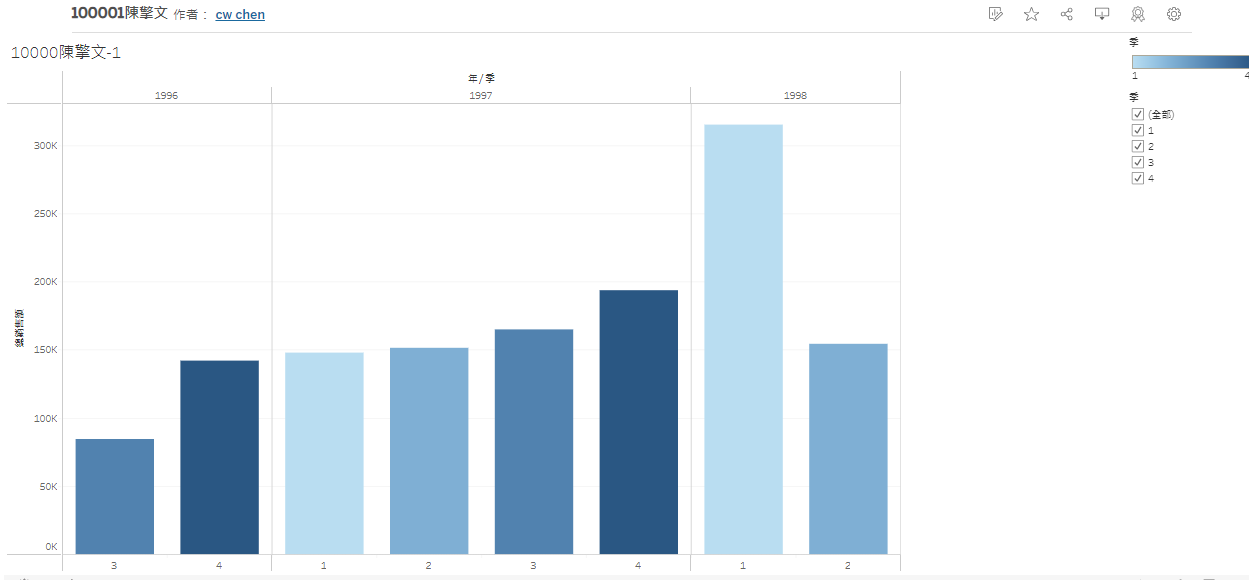

In [ ]:
'''
Tableau圖表的網址，貼在這裡：
https://public.tableau.com/app/profile/tsai.tsai/viz/111578053/2

'''

'\nTableau圖表的網址，貼在這裡：\n\n\n'

---
#22.產品銷售排名與庫存狀態(UnitsInStock)：
#對產品按銷售總量進行排名，並顯示其庫存狀態。

In [ ]:
import pandas as pd
sql = '''
SELECT products.ProductID,products.ProductName,sum(`order details`.Quantity) 總銷售額,products.UnitsInStock 目前庫存 FROM `order details`,categories,orders,products where categories.CategoryID=products.CategoryID
and `order details`.ProductID=products.ProductID
and `order details`.OrderID=orders.OrderID
group by products.ProductID
order by sum(`order details`.Quantity) desc;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-19-38a03821abb4>:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,總銷售額,目前庫存
0,60,Camembert Pierrot,1577.0,19
1,59,Raclette Courdavault,1496.0,79
2,31,Gorgonzola Telino,1397.0,0
3,56,Gnocchi di nonna Alice,1263.0,21
4,16,Pavlova,1158.0,29
...,...,...,...,...
72,67,Laughing Lumberjack Lager,184.0,52
73,48,Chocolade,138.0,15
74,37,Gravad lax,125.0,11
75,15,Genen Shouyu,122.0,39


---
#23.客戶忠誠度分析：
#找出至少重複下單15次的客戶，


In [ ]:
import pandas as pd
sql = '''
SELECT orders.CustomerID,customers.CompanyName FROM orders,customers where orders.CustomerID=customers.CustomerID
group by orders.CustomerID
having count(orders.OrderID)>=15;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-11-2be78913fec4>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName
0,BERGS,Berglunds snabbkp
1,BONAP,Bon app'
2,ERNSH,Ernst Handel
3,FOLKO,Folk och f HB
4,FRANK,Frankenversand
5,HILAA,HILARION-Abastos
6,HUNGO,Hungry Owl All-Night Grocers
7,LEHMS,Lehmanns Marktstand
8,QUICK,QUICK-Stop
9,RATTC,Rattlesnake Canyon Grocery


---
# 關閉連線

In [ ]:
#關閉連線
#conn.close()